## Import All Necessary Libraries

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import groq.api as g
import groq.runner.tsp as tsp
from groqflow import groqit
import onnxruntime as ort
from groq.runtime import driver as runtime
import groq.runtime
import time, timeit

import numpy as np

import os
import sys, re
import subprocess
import matplotlib.pyplot as plt

## Define PrintIOP Function

In [6]:
def print_iop_stats(iopf):
    p = subprocess.check_output(['iop-utils', 'stats', iopf], encoding='utf8')

    mem_usage_block = ""
    capture = False
    for line in p.splitlines():
        if "Aggregate Utilization" in line:
            capture = True
            mem_usage_block += line + "\n"
            continue
        if capture:
            if line.strip() == "":
                break
            mem_usage_block += line + "\n"

    cycles = int(re.findall("Program is (\S+)", p)[0])
    compute_usec = float(cycles)*1e-3/0.9  # 900MHz
    print('[[Cycles reported by iop-utils]]')
    print(f'  {iopf}')
    print(f'  cycles={cycles}')
    print(f'  usec={compute_usec}')

    print("[[Aggregate Utilization]]")
    print(mem_usage_block.strip())

## Check All IOP Files

In [7]:
fullPrecision_iop_filepath = "/home/sfowler/Groq_PtychoNN/IOP/PtychoNN.iop"
quantized_iop_filepath = "/home/sfowler/Groq_PtychoNN/IOP/Quantized_PtychoNN.iop"

iop_256_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model256.iop"
iop_256_new_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model256_new.iop"

iop_512_64_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model_ptycho_512_64.iop"
iop_512_128_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model512_new.iop"
iop_512_256_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model_ptycho_512_256.iop"

iop_128_128_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model128_new.iop"
iop_128_nodown_filepath = "/home/sfowler/Groq_PtychoNN/IOP/recon_model128_nodown.iop"



print("Values for the Full Precision version of edgePtychoNN:")
print_iop_stats(fullPrecision_iop_filepath)
print()

print("Values for the Quantized version of edgePtychoNN:")
print_iop_stats(quantized_iop_filepath)
print()

print('-'*30)

print("Values for the Quantized version of edgePtychoNN with 256x256 Input:")
print_iop_stats(iop_256_filepath)
print()

print("Values for the Quantized version of PtychoNN with 256x256 Input:")
print_iop_stats(iop_256_new_filepath)
print()

print('-'*30)

print("Values for the Quantized version of PtychoNN with 512x512 Input and 64x64 Output:")
print_iop_stats(iop_512_64_filepath)
print()

print("Values for the Quantized version of PtychoNN with 512x512 Input and 128x128 Output:")
print_iop_stats(iop_512_128_filepath)
print()

print("Values for the Quantized version of PtychoNN with 512x512 Input and 256x256 Output:")
print_iop_stats(iop_512_256_filepath)
print()

print('-'*30)

print("Values for the Quantized version of PtychoNN with 128x128 Input and 128x128 Output On New Model:")
print_iop_stats(iop_128_128_filepath)
print()

print("Values for the Quantized version of PtychoNN with 128x128 Input and 128x128 Output On New Model With No Down Sampling:")
print_iop_stats(iop_128_nodown_filepath)
print()

Values for the Full Precision version of edgePtychoNN:
[[Cycles reported by iop-utils]]
  /home/sfowler/Groq_PtychoNN/IOP/PtychoNN.iop
  cycles=99693
  usec=110.77
[[Aggregate Utilization]]
Aggregate Utilization
---------------------
Memory West: 7.10 %
Memory East: 6.68 %
VXM: 7.05 %
SXM: 8.06 %
MXM: 4.74 %
IO: 0.00 %

Values for the Quantized version of edgePtychoNN:
[[Cycles reported by iop-utils]]
  /home/sfowler/Groq_PtychoNN/IOP/Quantized_PtychoNN.iop
  cycles=92263
  usec=102.51444444444445
[[Aggregate Utilization]]
Aggregate Utilization
---------------------
Memory West: 7.20 %
Memory East: 7.41 %
VXM: 7.46 %
SXM: 8.61 %
MXM: 5.04 %
IO: 0.00 %

------------------------------
Values for the Quantized version of edgePtychoNN with 256x256 Input:
[[Cycles reported by iop-utils]]
  /home/sfowler/Groq_PtychoNN/IOP/recon_model256.iop
  cycles=317420
  usec=352.6888888888889
[[Aggregate Utilization]]
Aggregate Utilization
---------------------
Memory West: 7.84 %
Memory East: 8.17 %
VX

## Create Graph Of Image Size Vs. Inference Time

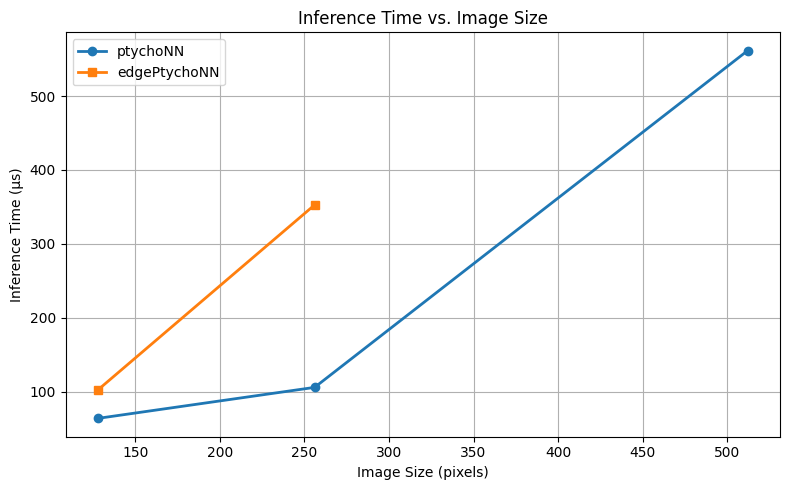

In [4]:
image_sizes = [128, 256, 512]
ptychoNN_inference_times = [63.8, 105.7, 561.3]

# edgePtychoNN only has 2 measurements
image_sizes_edge = [128, 256]
edgeptychoNN_inference_times = [102.5, 352.6]

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(image_sizes, ptychoNN_inference_times, label='ptychoNN', marker='o', linestyle='-', linewidth=2)
plt.plot(image_sizes_edge, edgeptychoNN_inference_times, label='edgePtychoNN', marker='s', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("Image Size (pixels)")
plt.ylabel("Inference Time (μs)")
plt.title("Inference Time vs. Image Size")
plt.grid(True)
plt.legend()

# Show plot
plt.tight_layout()
plt.show()

## Create All Models

In [66]:
class Quantizer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, n_bits):
        """Quantizes the input x to n_bits precision."""
        qmin, qmax = 0, 2 ** n_bits - 1
        scale = (x.max() - x.min()) / (qmax - qmin)
        x_q = torch.round(x / scale).clamp(qmin, qmax) * scale
        return x_q

    @staticmethod
    def backward(ctx, grad_output):
        """Straight-through estimator for gradient computation."""
        return grad_output, None

## 128 PtychoNN

In [67]:
class ReconSmallPhaseModel(nn.Module):
    def __init__(self, nconv: int = 16, n_bits: int = 8):
        super().__init__()
        self.nconv = nconv
        self.n_bits = n_bits

        # Encoder block (just conv layers, no downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, nconv, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(nconv, nconv * 2, 3, stride=1, padding=1),
            nn.ReLU()
        )

        # Decoder block (still no upsampling)
        self.decoder = nn.Sequential(
            nn.Conv2d(nconv * 2, nconv, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(nconv, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        with torch.cuda.amp.autocast():
            x = Quantizer.apply(x, self.n_bits)
            x = self.encoder(x)
            x = Quantizer.apply(x, self.n_bits)
            x = self.decoder(x)
            x = Quantizer.apply(x, self.n_bits)
            x = x * np.pi  # Map from [-1, 1] → [-π, π]
        return x


## 256 PtychoNN

In [68]:
class ReconSmallPhaseModel256(nn.Module):
    def __init__(self, nconv: int = 16, n_bits: int = 8):
        super().__init__()
        self.nconv = nconv
        self.n_bits = n_bits

        # Downsample: 256 → 128 → 64
        self.encoder = nn.Sequential(
            *self.down_block(1, nconv),
            *self.down_block(nconv, nconv * 2)  # 16 → 32
        )

        # Decoder keeps output at 128×128 (from 64 spatial size)
        self.decoder = nn.Sequential(
            nn.Conv2d(nconv * 2, nconv, 3, padding=1),  # 32 → 16
            nn.ReLU(),
            nn.Conv2d(nconv, 1, 3, padding=1),
            nn.Tanh()
        )

    def down_block(self, in_channels, out_channels):
        return [
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)  # Halves spatial size
        ]

    def forward(self, x):
        with torch.cuda.amp.autocast():
            x = Quantizer.apply(x, self.n_bits)
            x = self.encoder(x)
            x = Quantizer.apply(x, self.n_bits)
            x = self.decoder(x)
            x = Quantizer.apply(x, self.n_bits)
            x = x * np.pi  # Output phase in [-π, π]
        return x

## 512 PtychoNN

In [69]:
class ReconSmallPhaseModel512(nn.Module):
    def __init__(self, nconv: int = 16, n_bits: int = 8):
        super(ReconSmallPhaseModel512, self).__init__()
        self.nconv = nconv
        self.n_bits = n_bits

        # Two downsample steps: 512 -> 256 -> 128
        self.encoder = nn.Sequential(
            *self.down_block(1, self.nconv),
            *self.down_block(self.nconv, self.nconv * 2)
        )

        # Decoder stays at 128x128
        self.decoder2 = nn.Sequential(
            nn.Conv2d(self.nconv * 2, self.nconv * 2, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.nconv * 2, self.nconv, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.nconv, 1, 3, stride=1, padding=1),
            nn.Tanh()
        )

    def down_block(self, filters_in, filters_out):
        return [
            nn.Conv2d(filters_in, filters_out, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)  # Halve the resolution
        ]

    def forward(self, x):
        with torch.cuda.amp.autocast():
            x = Quantizer.apply(x, self.n_bits)
            x1 = self.encoder(x)
            x1 = Quantizer.apply(x1, self.n_bits)

            ph = self.decoder2(x1)
            ph = Quantizer.apply(ph, self.n_bits)
            ph = ph * np.pi

        return ph

## edgePtychoNN

In [81]:
class ReconSmallPhaseModelEdge(nn.Module):
    def __init__(self, nconv: int = 16, n_bits: int = 8):
        super(ReconSmallPhaseModelEdge, self).__init__()
        self.nconv = nconv
        self.n_bits = n_bits  # Number of bits for quantization
        self.encoder = nn.Sequential( # Appears sequential has similar functionality as TF avoiding need for separate model definition and activ
            *self.down_block(1, self.nconv),
            *self.down_block(self.nconv, self.nconv * 2),
            *self.down_block(self.nconv * 2, self.nconv * 4),
            *self.down_block(self.nconv * 4, self.nconv * 8), 
            *self.down_block(self.nconv * 8, self.nconv * 16), 
            *self.down_block(self.nconv * 16, self.nconv * 32),
            #*self.down_block(self.nconv * 32, self.nconv * 32)
        )
        
        # amplitude model
        #self.decoder1 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
         #   *self.up_block(self.nconv * 32, self.nconv * 16),
          #  *self.up_block(self.nconv * 16, self.nconv * 8),
           # *self.up_block(self.nconv * 8, self.nconv * 8),
            #*self.up_block(self.nconv * 8, self.nconv * 4),
            #*self.up_block(self.nconv * 4, self.nconv * 2),
            #*self.up_block(self.nconv * 2, self.nconv * 1),
            #nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
        #)
        
        # phase model
        self.decoder2 = nn.Sequential(
            #*self.up_block(self.nconv * 32, self.nconv * 32),
            *self.up_block(self.nconv * 32, self.nconv * 16),
            *self.up_block(self.nconv * 16, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 8),
            *self.up_block(self.nconv * 8, self.nconv * 4),
            *self.up_block(self.nconv * 4, self.nconv * 2),
            *self.up_block(self.nconv * 2, self.nconv * 1),
            nn.Conv2d(self.nconv * 1, 1, 3, stride=1, padding=(1,1)),
            nn.Tanh()
        )
    def down_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(in_channels=filters_in, out_channels=filters_out, kernel_size=3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.MaxPool2d((2,2))
        ]
        return block
    
    
    def up_block(self, filters_in, filters_out):
        block = [
            nn.Conv2d(filters_in, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Conv2d(filters_out, filters_out, 3, stride=1, padding=(1,1)),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear')
        ]
        return block
        
    
    def forward(self,x):
        with torch.cuda.amp.autocast():
            x = Quantizer.apply(x,self.n_bits)    # Apply quantization to input
            #print("Data type after quantization of inputs:", x.dtype)   # Print the data type after quantization
            
            x1 = self.encoder(x)
            x1 = Quantizer.apply(x1, self.n_bits) # Quantize feature maps
            #print("Size after encoder:", x1.size())  # Print size after encoder
            #print("Type after encoder:", x1.dtype)   # Print the data type after quantization

            #amp = self.decoder1(x1)
            ph = self.decoder2(x1)
            ph = Quantizer.apply(ph, self.n_bits)  #Quantize output

            #Restore -pi to pi range
            ph = ph*np.pi #Using tanh activation (-1 to 1) for phase so multiply by pi
            
        return ph

## Check Parameter Count

In [82]:
# 128 Input Model
model = ReconSmallPhaseModel() 
total_params = sum(p.numel() for p in model.parameters())
print(f"The number of parameters in the 128x128 input file is: {total_params:,}")

# 256 Input Model
model = ReconSmallPhaseModel256() 
total_params = sum(p.numel() for p in model.parameters())
print(f"The number of parameters in this 256x256 input file is: {total_params:,}")

# 512 Input Model
model = ReconSmallPhaseModel512()  
total_params = sum(p.numel() for p in model.parameters())
print(f"The number of parameters in this 512x512 input file is: {total_params:,}")

model = ReconSmallPhaseModelEdge()  
total_params = sum(p.numel() for p in model.parameters())
print(f"The number of parameters in this edgePtychoNN file is: {total_params:,}")


The number of parameters in the 128x128 input file is: 9,569
The number of parameters in this 256x256 input file is: 21,137
The number of parameters in this 512x512 input file is: 30,385
The number of parameters in this edgePtychoNN file is: 7,371,745


## Create Graph of Image Size Vs. Parameter Count

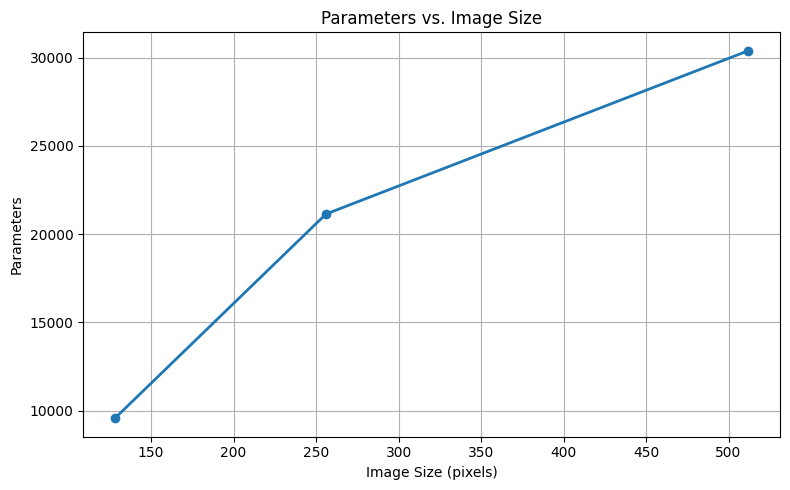

[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 114
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 114
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 0
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 0
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 116
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 116
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 164
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 55
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 114
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 29
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 114
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 197
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 97
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 67
[groq:401453] tcp_peer_recv_connect_ack: invalid header type: 48
[groq:401453] tcp_p

In [72]:
# Data
image_sizes = [128, 256, 512]
inference_times = [9569, 21137, 30385]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(image_sizes, inference_times, marker='o', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel("Image Size (pixels)")
plt.ylabel("Parameters")
plt.title("Parameters vs. Image Size")
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()